## Time Series Analysis: Forecasting Regional Electrical Demand

### Steps

* Loading the Data
* Basic EDA
* Exploring Drift and Seasonality
* Modeling Seasonal Background Load
* Load forecasting

In [210]:
import datetime as dt
import numpy as np
import pandas as pd

from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [211]:
#!wget https://raw.githubusercontent.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data/master/data/release_2020_Oct/regions/NE.csv

In [212]:
df_NE = pd.read_csv('NE.csv')
df_NE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            43848 non-null  object 
 1   raw demand (MW)      43848 non-null  float64
 2   cleaned demand (MW)  43848 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.0+ MB


In [213]:
df_NE.columns = df_NE.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_NE['date_time'] = pd.to_datetime(df_NE['date_time'])
df_NE.head()

,date_time,raw_demand_MW,cleaned_demand_MW
0,2015-07-02 00:00:00,17653.0,17653
1,2015-07-02 01:00:00,17286.0,17286
2,2015-07-02 02:00:00,16701.0,16701
3,2015-07-02 03:00:00,15220.0,15220
4,2015-07-02 04:00:00,13594.0,13594


In [214]:
df_NE.describe()

,date_time,raw_demand_MW,cleaned_demand_MW
count,43848,43848.000000,43848.000000
mean,2017-12-31 11:30:00,13874.842501,13875.772099
min,2015-07-02 00:00:00,0.000000,8494.000000
25%,2016-09-30 17:45:00,12011.000000,12011.000000
50%,2017-12-31 11:30:00,13588.000000,13588.500000
75%,2019-04-02 05:15:00,15310.000000,15310.000000
max,2020-07-01 23:00:00,25763.000000,25763.000000
std,NaN,2598.584172,2596.024883


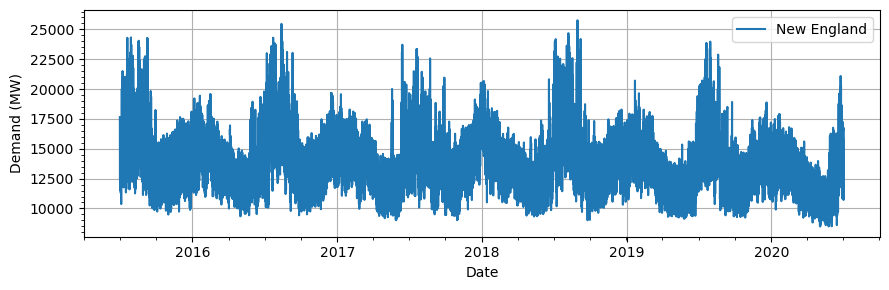

In [215]:
plt.figure(figsize=(9,3))
plt.plot(df_NE['date_time'], df_NE['cleaned_demand_MW'], label='New England')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.minorticks_on()
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

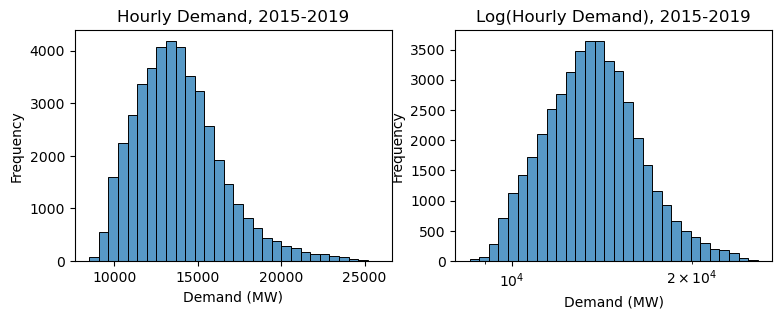

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

sns.histplot(data=df_NE, x='cleaned_demand_MW', bins=30, ax=axes[0])
axes[0].set_xlabel('Demand (MW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Hourly Demand, 2015-2019')

sns.histplot(data=df_NE, x='cleaned_demand_MW', bins=30, log_scale=True, ax=axes[1])
axes[1].set_xlabel('Demand (MW)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log(Hourly Demand), 2015-2019')

plt.show()

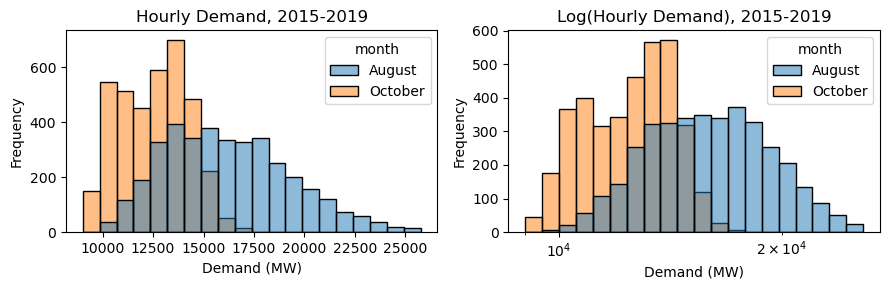

In [217]:
df_NE['month'] = df_NE['date_time'].dt.strftime('%B')

plotmonths = [8, 10]
df_seasonal = df_NE[df_NE['date_time'].dt.month.isin(plotmonths)]

fig, axes = plt.subplots(1, 2, figsize=(9, 3))

sns.histplot(data=df_seasonal, x='cleaned_demand_MW', bins=20, hue='month', ax=axes[0])
axes[0].set_xlabel('Demand (MW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Hourly Demand, 2015-2019')

sns.histplot(data=df_seasonal, x='cleaned_demand_MW', bins=20, hue='month', log_scale=True, ax=axes[1])
axes[1].set_xlabel('Demand (MW)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log(Hourly Demand), 2015-2019')

plt.tight_layout()
plt.show()

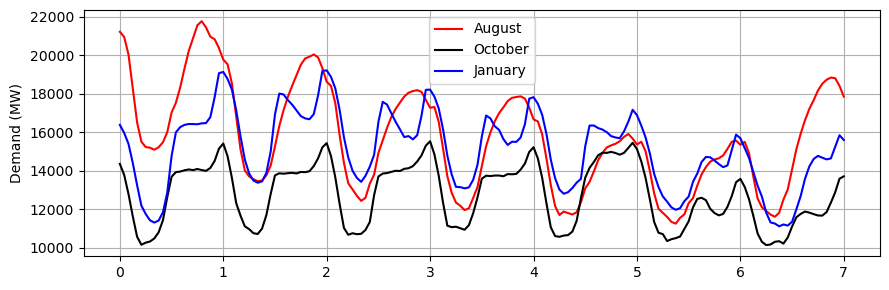

In [218]:
start_date1 = pd.to_datetime('2015-08-04 00:00:00')
end_date1 = pd.to_datetime('2015-08-11 00:00:00')

start_date2 = pd.to_datetime('2015-10-05 00:00:00')
end_date2 = pd.to_datetime('2015-10-12 00:00:00')

start_date3 = pd.to_datetime('2016-01-04 00:00:00')
end_date3 = pd.to_datetime('2016-01-11 00:00:00')

subset1 = df_NE.loc[(df_NE['date_time'] >= start_date1) & (df_NE['date_time'] <= end_date1)].copy()
subset2 = df_NE.loc[(df_NE['date_time'] >= start_date2) & (df_NE['date_time'] <= end_date2)].copy()
subset3 = df_NE.loc[(df_NE['date_time'] >= start_date3) & (df_NE['date_time'] <= end_date3)].copy()


plt.figure(figsize=(9,3))
plt.plot((subset1['date_time']-start_date1)/dt.timedelta(days=1), subset1['cleaned_demand_MW'], label='August', color='red')
plt.plot((subset2['date_time']-start_date2)/dt.timedelta(days=1), subset2['cleaned_demand_MW'], label='October', color='black')
plt.plot((subset3['date_time']-start_date3)/dt.timedelta(days=1), subset3['cleaned_demand_MW'], label='January', color='blue')
plt.ylabel('Demand (MW)')


plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

## Cross-validation for time series

In [219]:
columns = ['date_time', 'cleaned_demand_MW']

train_start = pd.to_datetime('2015-07-02 00:00:00')
train_end = pd.to_datetime('2018-07-01 23:00:00')

val_start = pd.to_datetime('2018-07-02 00:00:00')
val_end = pd.to_datetime('2019-07-01 23:00:00')

test_start = pd.to_datetime('2019-07-02 00:00:00')
test_end = pd.to_datetime('2020-07-01 23:00:00')

df_train = df_NE.loc[(df_NE['date_time'] >= train_start) & (df_NE['date_time'] <= train_end)].copy()[columns]
df_val = df_NE.loc[(df_NE['date_time'] >= val_start) & (df_NE['date_time'] <= val_end)].copy()[columns]
df_test = df_NE.loc[(df_NE['date_time'] >= test_start) & (df_NE['date_time'] <= test_end)].copy()[columns]

In [220]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_time          26304 non-null  datetime64[ns]
 1   cleaned_demand_MW  26304 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 616.5 KB


## Mean Model

A good baseline is the mean model, which has a MSE equal to the variance of the data. We'll take the square root to look at RMSE. Another metric we can consider is the 𝑅<sup>2</sup> score. This will be very bad for the mean model. 

In [221]:
np.sqrt(df_val.cleaned_demand_MW.var())

2684.356183757364

In [222]:
metrics.r2_score(df_val.cleaned_demand_MW, [df_val.cleaned_demand_MW.mean()]*len(df_val.cleaned_demand_MW))

0.0

## Indicator Features Model

In [295]:
class HourofDay(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, column_name='target', horizon=0):
        self.column_name=column_name
        self.horizon = horizon
    
    def fit(self, X, y=None):
        return self
    
    def hour_vector(self, hour):
        v = np.zeros(24)
        v[hour] = 1
        return v
    
    def transform(self, X):
        # Adjust the timestamp with the horizon offset
        adjusted_timestamp = X[self.column_name] + pd.DateOffset(hours=self.horizon)
        
        # Extract the hour of the day for the adjusted timestamp
        hour_of_day = adjusted_timestamp.dt.hour
        
        return np.stack([self.hour_vector(h) for h in hour_of_day])

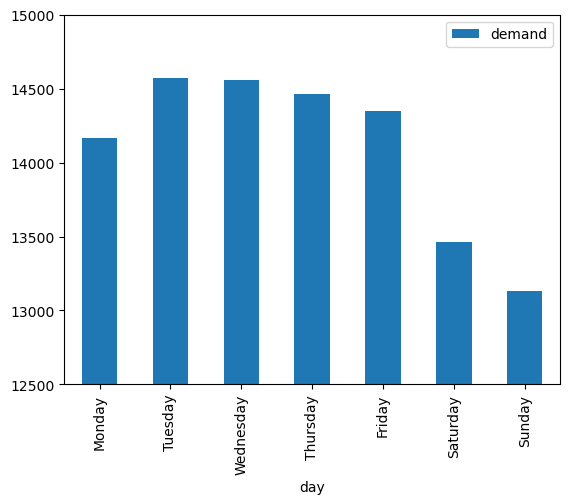

In [224]:
day_df = pd.DataFrame(
    {'day': df_train.date_time.dt.dayofweek, 'demand': df_train.cleaned_demand_MW.values}
)

ax = day_df.groupby('day').mean().plot(kind='bar')
ax.set_ylim(12500, 15000)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

In [296]:
class DayofWeek(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, column_name='target', horizon=0):
        self.column_name=column_name
        self.horizon=horizon
    
    def fit(self, X, y=None):
        return self
    
    def weekday_vector(self, weekday):
        v = np.zeros(7)
        v[weekday] = 1
        return v
    
    def transform(self, X):
        # Adjust the timestamp with the horizon offset
        adjusted_timestamp = X[self.column_name] + pd.DateOffset(hours=self.horizon)
        
        # Extract the day of the week for the adjusted timestamp
        day_of_week = adjusted_timestamp.dt.dayofweek
        
        return np.stack([self.weekday_vector(d) for d in day_of_week])

In [297]:
class MonthofYear(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, column_name='target', horizon=0):
        self.column_name=column_name
        self.horizon=horizon
    
    def fit(self, X, y=None):
        return self
    
    def month_vector(self, month):
        v = np.zeros(12)
        v[month-1] = 1
        return v
    
    def transform(self, X):
        # Adjust the timestamp with the horizon offset
        adjusted_timestamp = X[self.column_name] + pd.DateOffset(hours=self.horizon)
        
        # Extract the hour of the day for the adjusted timestamp
        month_of_year = adjusted_timestamp.dt.month
        
        return np.stack([self.month_vector(m) for m in month_of_year])

In [227]:
union = FeatureUnion([('monthofyear', MonthofYear(column_name='date_time')),
                      ('dayofweek', DayofWeek(column_name='date_time')),
                      ('hourofday',HourofDay(column_name='date_time'))])
indicator_pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

In [228]:
y_train = np.log1p(df_train.cleaned_demand_MW.values)

In [229]:
indicator_model = indicator_pipe.fit(df_train, y_train)

In [230]:
y_train_base_pred = np.expm1(indicator_model.predict(df_train))
y_val_base_pred = np.expm1(indicator_model.predict(df_val))

In [231]:
def plot_demand_actual_vs_predicted(df, actual_column, predicted_data, start_date, end_date):
    plt.figure(figsize=(9, 3))
    plt.plot(df['date_time'], df[actual_column], label='Actual')
    plt.plot(df['date_time'], predicted_data, label='Predicted')
    plt.xlim([pd.to_datetime(start_date), pd.to_datetime(end_date)])
    plt.xlabel('Date')
    plt.ylabel('Demand (MW)')
    plt.minorticks_on()
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

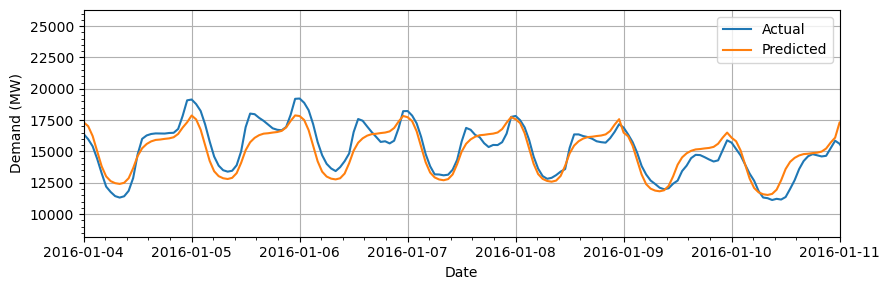

In [232]:
plot_demand_actual_vs_predicted(df_train, 'cleaned_demand_MW', y_train_base_pred,
                                '2016-01-04 00:00:00', '2016-01-11 00:00:00')

In [233]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_train.cleaned_demand_MW.astype('float64'),
                                                  y_train_base_pred)))
print("R^2:", metrics.r2_score(df_train.cleaned_demand_MW.astype('float64'), y_train_base_pred))

RMSE: 1449.0711082323817
R^2: 0.678559768919281


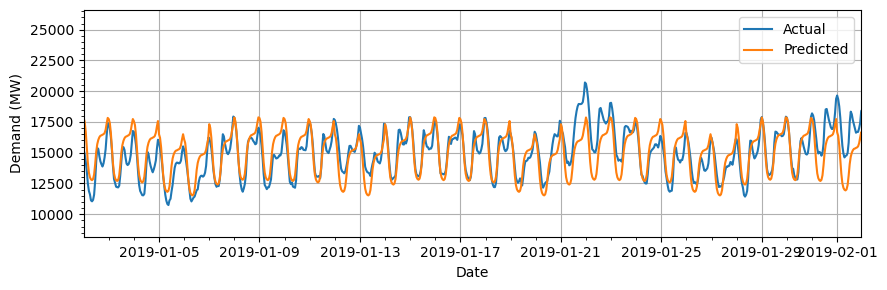

In [234]:
plot_demand_actual_vs_predicted(df_val, 'cleaned_demand_MW', y_val_base_pred, 
                                '2019-01-02 00:00:00', '2019-02-01 23:00:00')

In [235]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_val.cleaned_demand_MW.astype('float64'),
                                                  y_val_base_pred)))
print("R^2:", metrics.r2_score(df_val.cleaned_demand_MW.astype('float64'), y_val_base_pred))

RMSE: 1536.1003042146494
R^2: 0.6725021542676921


## Modeling the "noise"

In [236]:
df_train['base_demand'] = y_train_base_pred
df_train['demand_anomaly'] = df_train['cleaned_demand_MW'] - df_train['base_demand']

df_val['base_demand'] = y_val_base_pred
df_val['demand_anomaly'] = df_val['cleaned_demand_MW'] - df_val['base_demand']

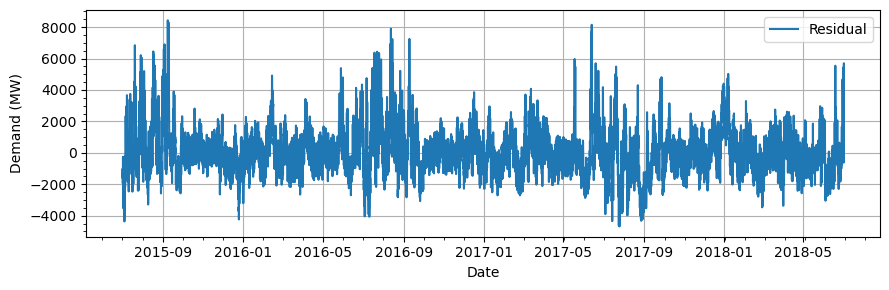

In [237]:
plt.figure(figsize=(9,3))
plt.plot(df_train['date_time'], df_train['demand_anomaly'], label='Residual')
#plt.xlim([pd.to_datetime('2016-01-04 00:00:00'), pd.to_datetime('2016-01-11 00:00:00')])
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.minorticks_on()
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

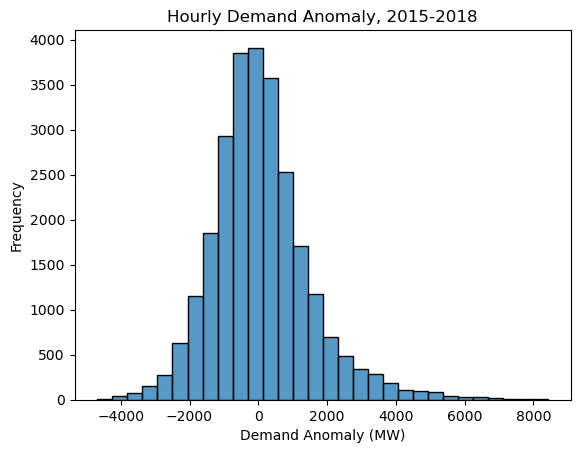

In [238]:
sns.histplot(data=df_train, x='demand_anomaly', bins=30)
plt.xlabel('Demand Anomaly (MW)')
plt.ylabel('Frequency')
plt.title('Hourly Demand Anomaly, 2015-2018')
plt.show()

In [239]:
df_train.demand_anomaly.describe()

count    26304.000000
mean        69.059055
std       1447.452097
min      -4683.038076
25%       -814.034004
50%        -66.633551
75%        757.831480
max       8433.066560
Name: demand_anomaly, dtype: float64

In [240]:
np.sqrt(df_val.demand_anomaly.var())

1527.6325171956

In [241]:
metrics.r2_score(df_val.demand_anomaly, [df_val.demand_anomaly.mean()]*len(df_val.demand_anomaly))

0.0

### Autocorrelation

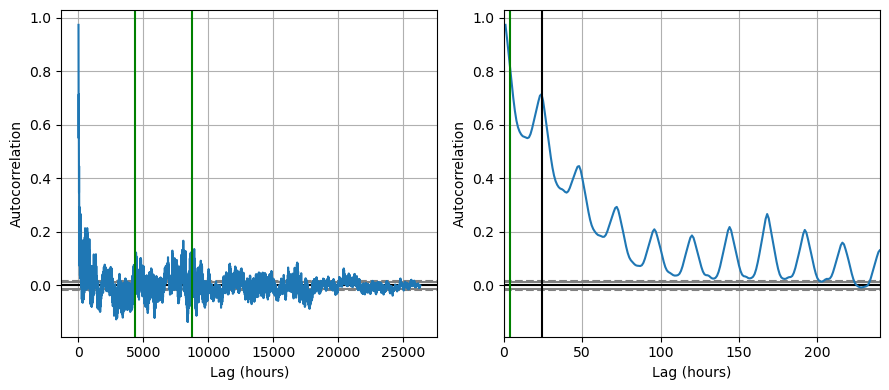

In [242]:
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

autocorrelation_plot(df_train['demand_anomaly'], ax=axes[0])
axes[0].set_xlabel('Lag (hours)')
axes[0].axvline(24*182, color = 'green')
axes[0].axvline(24*365, color = 'green')

autocorrelation_plot(df_train['demand_anomaly'], ax=axes[1])
axes[1].set_xlabel('Lag (hours)')
axes[1].axvline(4, color = 'green')
axes[1].axvline(24, color = 'black')
plt.xlim([0, 240])

plt.tight_layout()
plt.show();

In [243]:
df_train.head()

,date_time,cleaned_demand_MW,base_demand,demand_anomaly
0,2015-07-02 00:00:00,17653,19053.756253,-1400.756253
1,2015-07-02 01:00:00,17286,18719.450711,-1433.450711
2,2015-07-02 02:00:00,16701,17849.100265,-1148.100265
3,2015-07-02 03:00:00,15220,16514.698807,-1294.698807
4,2015-07-02 04:00:00,13594,15196.340622,-1602.340622


### Feature Engineering

In [244]:
class LagTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, column_name='label', lag=1):
        self.lag=lag
        self.column_name=column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create a copy of the input DataFrame to avoid altering the original
        X_copy = X.copy()
        
        # Shift the specified column by 'lag' rows
        if self.lag <= len(X) - 1:
            X_copy[f'{self.column_name}-{self.lag}'] = X_copy[self.column_name].shift(self.lag)
            X_copy[f'{self.column_name}-{self.lag}'] = X_copy[f'{self.column_name}-{self.lag}'].fillna(method='bfill', axis=0)
            return X_copy[[f'{self.column_name}-{self.lag}']]
        else:
            print(f'Requested shift {self.lag} > number of records. Returning {self.column_name}-{len(X_copy)-1}')
            X_copy[f'{self.column_name}-{len(X_copy)-1}'] = X_copy[self.column_name].shift(len(X_copy) - 1)
            X_copy[f'{self.column_name}-{len(X_copy)-1}'] = X_copy[f'{self.column_name}-{len(X_copy)-1}'].fillna(method='bfill', axis=0)
            return X_copy[f'{self.column_name}-{len(X_copy)-1}']

In [262]:
union = FeatureUnion([('lag_1', LagTransformer(column_name='demand_anomaly', lag=1)),
                      ('lag_2', LagTransformer(column_name='demand_anomaly', lag=2)),
                      ('lag_3', LagTransformer(column_name='demand_anomaly', lag=3)),
                      ('lag_4', LagTransformer(column_name='demand_anomaly', lag=4))])

maxdepths=[1, 2, 3, 4, 6, 8, 10, 12, 16, 20]

for md in maxdepths:
    nlr = ensemble.RandomForestRegressor(n_estimators=20, max_depth=md)
    residual_pipe = Pipeline([('union', union), 
                              ('Random Forest', nlr)])
    residual_model = residual_pipe.fit(df_train, df_train.demand_anomaly.astype('float64'))
    y_train_resid_pred = residual_model.predict(df_train)
    y_val_resid_pred = residual_model.predict(df_val)
    trainRMSE= np.sqrt(metrics.mean_squared_error(df_train.demand_anomaly.astype('float64'), y_train_resid_pred))
    valRMSE= np.sqrt(metrics.mean_squared_error(df_val.demand_anomaly.astype('float64'), y_val_resid_pred))
    print(f'max_depth={md}: Train RMSE={trainRMSE}, Val RMSE={valRMSE}')

max_depth=1: Train RMSE=959.9089544208512, Val RMSE=1034.3494782992589
max_depth=2: Train RMSE=600.6411148897579, Val RMSE=631.221057092014
max_depth=3: Train RMSE=408.3660256080845, Val RMSE=427.2080880150366
max_depth=4: Train RMSE=341.1855838003658, Val RMSE=360.04323650232163
max_depth=6: Train RMSE=294.66011501522985, Val RMSE=315.3046212319295
max_depth=8: Train RMSE=269.22922813372213, Val RMSE=298.41954297255984
max_depth=10: Train RMSE=239.2315028364693, Val RMSE=295.95427104501533
max_depth=12: Train RMSE=204.075254820454, Val RMSE=298.38476996570614
max_depth=16: Train RMSE=146.3312809738486, Val RMSE=303.26137497869985
max_depth=20: Train RMSE=123.49030678316939, Val RMSE=305.65465147908526


In [246]:
minsamples = [2, 3, 4, 6, 8, 10, 12, 16, 20]

for ms in minsamples:
    nlr = ensemble.RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=ms)
    residual_pipe = Pipeline([('union', union), 
                              ('Random Forest', nlr)])
    residual_model = residual_pipe.fit(df_train, df_train.demand_anomaly.astype('float64'))
    y_train_resid_pred = residual_model.predict(df_train)
    y_val_resid_pred = residual_model.predict(df_val)
    trainRMSE= np.sqrt(metrics.mean_squared_error(df_train.demand_anomaly.astype('float64'), y_train_resid_pred))
    valRMSE= np.sqrt(metrics.mean_squared_error(df_val.demand_anomaly.astype('float64'), y_val_resid_pred))
    print(f'min_samples_split={ms}: Train RMSE={trainRMSE}, Val RMSE={valRMSE}')

min_samples_split=2: Train RMSE=238.85468125342928, Val RMSE=296.5515511289452
min_samples_split=3: Train RMSE=239.14883197527328, Val RMSE=295.80261588925697
min_samples_split=4: Train RMSE=239.5353086944322, Val RMSE=296.4575174348228
min_samples_split=6: Train RMSE=241.08871326275874, Val RMSE=296.7098839601879
min_samples_split=8: Train RMSE=242.40984252438136, Val RMSE=295.4737143735798
min_samples_split=10: Train RMSE=243.20339401393298, Val RMSE=296.4097347364662
min_samples_split=12: Train RMSE=244.6384456416663, Val RMSE=295.55091051279044
min_samples_split=16: Train RMSE=247.74502731915356, Val RMSE=296.1643321951643
min_samples_split=20: Train RMSE=249.11526138322768, Val RMSE=296.2784255264318


In [263]:
nlr = ensemble.RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=3)
residual_pipe = Pipeline([('union', union), 
                          ('Random Forest', nlr)])
residual_model = residual_pipe.fit(df_train, df_train.demand_anomaly.astype('float64'))

In [264]:
y_train_resid_pred = residual_model.predict(df_train)
y_val_resid_pred = residual_model.predict(df_val)

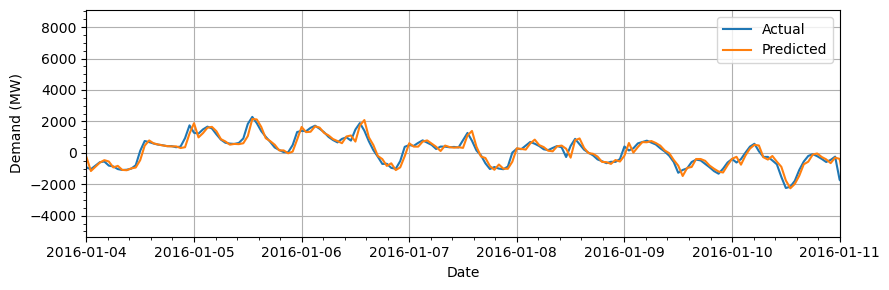

In [265]:
plot_demand_actual_vs_predicted(df_train, 'demand_anomaly', y_train_resid_pred,
                                '2016-01-04 00:00:00', '2016-01-11 00:00:00')

In [266]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_train.demand_anomaly.astype('float64'),
                                                  y_train_resid_pred)))
print("R^2:", metrics.r2_score(df_train.demand_anomaly.astype('float64'), y_train_resid_pred))

RMSE: 239.44412286244986
R^2: 0.9726336753492484


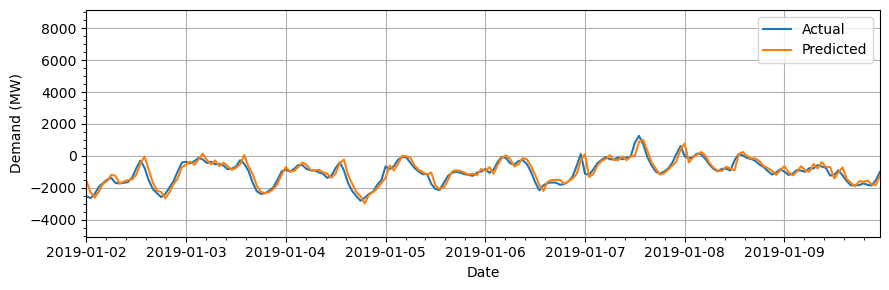

In [267]:
plot_demand_actual_vs_predicted(df_val, 'demand_anomaly', y_val_resid_pred,
                                '2019-01-02 00:00:00', '2019-01-09 23:00:00')

In [268]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_val.demand_anomaly.astype('float64'),
                                                  y_val_resid_pred)))
print("R^2:", metrics.r2_score(df_val.demand_anomaly.astype('float64'), y_val_resid_pred))

RMSE: 296.9444109959838
R^2: 0.9622112868764418


In [269]:
df_train['predicted_anomaly'] = y_train_resid_pred
df_train['predicted_demand'] = df_train.base_demand + df_train['predicted_anomaly']

In [270]:
df_train.head()

,date_time,cleaned_demand_MW,base_demand,demand_anomaly,predicted_anomaly,predicted_demand
0,2015-07-02 00:00:00,17653,19053.756253,-1400.756253,-1333.831340,17719.924913
1,2015-07-02 01:00:00,17286,18719.450711,-1433.450711,-1333.831340,17385.619371
2,2015-07-02 02:00:00,16701,17849.100265,-1148.100265,-1366.031094,16483.069171
3,2015-07-02 03:00:00,15220,16514.698807,-1294.698807,-978.418839,15536.279968
4,2015-07-02 04:00:00,13594,15196.340622,-1602.340622,-1357.851469,13838.489152


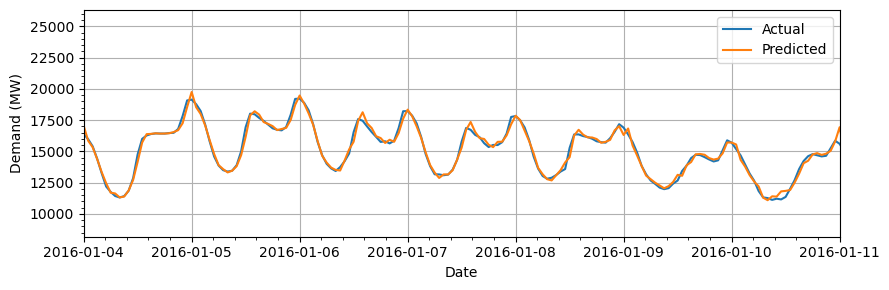

In [271]:
plot_demand_actual_vs_predicted(df_train, 'cleaned_demand_MW', df_train['predicted_demand'],
                                '2016-01-04 00:00:00', '2016-01-11 00:00:00')

In [272]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_train.cleaned_demand_MW.astype('float64'),
                                                  df_train.predicted_demand.astype('float64'))))
print("R^2:", metrics.r2_score(df_train.cleaned_demand_MW.astype('float64'),
                                                  df_train.predicted_demand.astype('float64')))

RMSE: 239.44412286244983
R^2: 0.991223341502561


In [273]:
df_val['predicted_anomaly'] = y_val_resid_pred
df_val['predicted_demand'] = df_val.base_demand + df_val['predicted_anomaly']

In [274]:
df_val.head()

,date_time,cleaned_demand_MW,base_demand,demand_anomaly,predicted_anomaly,predicted_demand
26304,2018-07-02 00:00:00,22008,18615.761819,3392.238181,3205.417069,21821.178888
26305,2018-07-02 01:00:00,21444,18289.140655,3154.859345,3205.417069,21494.557725
26306,2018-07-02 02:00:00,20695,17438.796168,3256.203832,2771.124923,20209.921091
26307,2018-07-02 03:00:00,19005,16135.067388,2869.932612,3243.868466,19378.935854
26308,2018-07-02 04:00:00,17439,14847.013109,2591.986891,2529.561126,17376.574235


In [275]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_val.cleaned_demand_MW.astype('float64'),
                                                  df_val.predicted_demand.astype('float64'))))
print("R^2:", metrics.r2_score(df_val.cleaned_demand_MW.astype('float64'),
                                                  df_val.predicted_demand.astype('float64')))

RMSE: 296.9444109959838
R^2: 0.9877617418936832


### Forecasting

In [323]:
y_train_f0 = np.log1p(df_train['cleaned_demand_MW'])
y_train_f2 = np.log1p(df_train['cleaned_demand_MW'].shift(-2).fillna(method='ffill'))

In [308]:
season_union_f0 = FeatureUnion([('monthofyear', MonthofYear(column_name='date_time')),
                                ('dayofweek', DayofWeek(column_name='date_time')),
                                ('hourofday',HourofDay(column_name='date_time'))])
season_f0_pipe = Pipeline([('union', season_union_f0),
                           ('lr', LinearRegression())])

season_model_f0 = season_f2_pipe.fit(df_train, y_train_f0)

season_union_f2 = FeatureUnion([('monthofyear', MonthofYear(column_name='date_time', horizon=2)),
                                ('dayofweek', DayofWeek(column_name='date_time', horizon=2)),
                                ('hourofday',HourofDay(column_name='date_time', horizon=2))])
season_f2_pipe = Pipeline([('union', season_union_f2),
                           ('lr', LinearRegression())])


season_model_f2 = season_f2_pipe.fit(df_train, y_train_f2)


In [309]:
df_train.head()

,date_time,cleaned_demand_MW,base_demand,demand_anomaly,predicted_anomaly,predicted_demand
0,2015-07-02 00:00:00,17653,19053.756253,-1400.756253,-1333.831340,17719.924913
1,2015-07-02 01:00:00,17286,18719.450711,-1433.450711,-1333.831340,17385.619371
2,2015-07-02 02:00:00,16701,17849.100265,-1148.100265,-1366.031094,16483.069171
3,2015-07-02 03:00:00,15220,16514.698807,-1294.698807,-978.418839,15536.279968
4,2015-07-02 04:00:00,13594,15196.340622,-1602.340622,-1357.851469,13838.489152


In [336]:
f0_train = pd.DataFrame()
f0_train[['date_time', 'demand_MW']] = df_train[['date_time', 'cleaned_demand_MW']]
f0_train['base_demand_f0'] = np.expm1(season_model_f0.predict(df_train))
f0_train['demand_anomaly_f0'] = f0_train['demand_MW'] - f0_train['base_demand_f0']

f2_train = pd.DataFrame()
f2_train['prediction_time_f2'] = df_train.date_time + pd.DateOffset(hours=2)
f2_train['pred_base_demand_f2'] = np.expm1(season_model_f2.predict(df_train))

In [338]:
f0_train.head()

,date_time,demand_MW,base_demand_f0,demand_anomaly_f0
0,2015-07-02 00:00:00,17653,19058.990517,-1405.990517
1,2015-07-02 01:00:00,17286,18712.596332,-1426.596332
2,2015-07-02 02:00:00,16701,17851.824182,-1150.824182
3,2015-07-02 03:00:00,15220,16516.210933,-1296.210933
4,2015-07-02 04:00:00,13594,15195.413078,-1601.413078


In [339]:
y_train_anom_f2 = f0_train['demand_anomaly_f0'].shift(-2).fillna(method='ffill')

In [341]:
y_train_anom_f2.head()

0   -1150.824182
1   -1296.210933
2   -1601.413078
3   -1299.041070
4   -1011.613739
Name: demand_anomaly_f0, dtype: float64

In [342]:
lag_union = FeatureUnion([('lag_0', LagTransformer(column_name='demand_anomaly_f0', lag=0)),
                          ('lag_1', LagTransformer(column_name='demand_anomaly_f0', lag=1)),
                          ('lag_2', LagTransformer(column_name='demand_anomaly_f0', lag=2)),
                          ('lag_3', LagTransformer(column_name='demand_anomaly_f0', lag=3)),
                          ('lag_4', LagTransformer(column_name='demand_anomaly_f0', lag=4))
                         ])

nlr = ensemble.RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=3)
rf_residual_pipe = Pipeline([('lag_union', lag_union), 
                          ('Random Forest', nlr)])

residual_model_f2 = rf_residual_pipe.fit(f0_train, y_train_anom_f2)

In [345]:
f2_train['pred_anomaly_f2'] = residual_model_f2.predict(f0_train)
f2_train['pred_demand_f2'] = f2_train.pred_base_demand_f2 + f2_train.pred_anomaly_f2

In [346]:
f2_train.head()

,prediction_time_f2,pred_base_demand_f2,pred_anomaly_f2,pred_demand_f2
0,2015-07-02 02:00:00,17824.059721,-1287.118880,16536.940842
1,2015-07-02 03:00:00,16491.530193,-1232.710247,15258.819945
2,2015-07-02 04:00:00,15175.021432,-767.024101,14407.997330
3,2015-07-02 05:00:00,14289.965202,-1220.440317,13069.524885
4,2015-07-02 06:00:00,13873.546859,-1646.031589,12227.515271


In [348]:
results = f0_train.merge(f2_train, left_on='date_time', right_on='prediction_time_f2')
results.head()

,date_time,demand_MW,base_demand_f0,demand_anomaly_f0,prediction_time_f2,pred_base_demand_f2,pred_anomaly_f2,pred_demand_f2
0,2015-07-02 02:00:00,16701,17851.824182,-1150.824182,2015-07-02 02:00:00,17824.059721,-1287.118880,16536.940842
1,2015-07-02 03:00:00,15220,16516.210933,-1296.210933,2015-07-02 03:00:00,16491.530193,-1232.710247,15258.819945
2,2015-07-02 04:00:00,13594,15195.413078,-1601.413078,2015-07-02 04:00:00,15175.021432,-767.024101,14407.997330
3,2015-07-02 05:00:00,13011,14310.041070,-1299.041070,2015-07-02 05:00:00,14289.965202,-1220.440317,13069.524885
4,2015-07-02 06:00:00,12881,13892.613739,-1011.613739,2015-07-02 06:00:00,13873.546859,-1646.031589,12227.515271


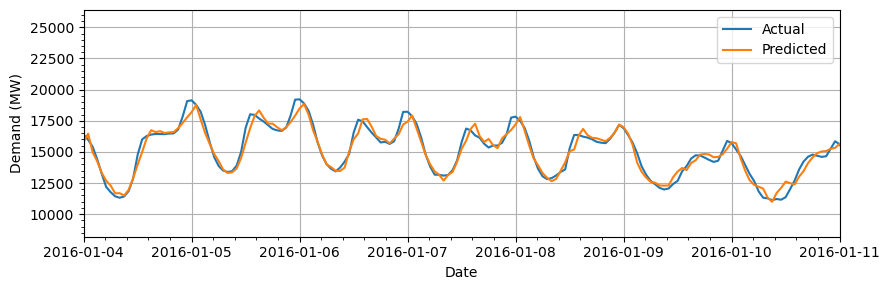

In [350]:
plot_demand_actual_vs_predicted(results, 'demand_MW', results['pred_demand_f2'],
                                '2016-01-04 00:00:00', '2016-01-11 00:00:00')

In [349]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(results.demand_MW, results.pred_demand_f2)))
print("R^2:", metrics.r2_score(results.demand_MW, results.pred_demand_f2))

RMSE: 418.7794440507008
R^2: 0.9731517420759668


### Putting it all together

Code to:

* take in a dataframe with hourly timestamps and measured demand values,
* take a parameter for forecast horizon,
* train an indicator features model for current base demand (seasonal)
* subtract current base demand from current demand to find current anomaly (random),
* shift the demand signal to match the desired forecast horizon to use as training target,
* train a model of lag features on the anomaly at the forecast horizon
* use the indicator model to predict base demand at horizon,
* use the resdiduals model to predict the anomaly at the horizon,
* add predicted base demand to predicted anomaly to get the predicted demand


In [97]:
df_train_plus2 = make_future_value(df_train, ['date_time', 'cleaned_demand_MW'], [2])
df_train_plus2.tail()

,date_time,date_time_plus2,cleaned_demand_MW,cleaned_demand_MW_plus2
26299,2018-07-01 19:00:00,2018-07-01 21:00:00,21095,22068.0
26300,2018-07-01 20:00:00,2018-07-01 22:00:00,21568,22517.0
26301,2018-07-01 21:00:00,2018-07-01 23:00:00,22068,22498.0
26302,2018-07-01 22:00:00,2018-07-01 23:00:00,22517,22498.0
26303,2018-07-01 23:00:00,2018-07-01 23:00:00,22498,22498.0


In [98]:
df_train = df_train[['date_time', 'cleaned_demand_MW']]
df_val = df_val[['date_time', 'cleaned_demand_MW']]

In [99]:
df_test.head()

,date_time,cleaned_demand_MW
35064,2019-07-02 00:00:00,17918
35065,2019-07-02 01:00:00,17400
35066,2019-07-02 02:00:00,16700
35067,2019-07-02 03:00:00,15190
35068,2019-07-02 04:00:00,13623


In [100]:
# create a future demand target dataframe
def make_future_value(df, target_list, horizonlist):
    #accepts dataframe, target column (string) and horizon(+integer), adds prediction column to dataframe
    future = pd.DataFrame()
    future['date_time'] = df['date_time']
    
    for target in target_list:
        future[target] = df[target]
        for horizon in horizonlist:
            future[f'{target}_plus{horizon}'] = df[target].shift(-(horizon)).fillna(method='ffill')
    
    return future